## 6. Decision Trees and Ensemble Learning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.isnull().sum()


neighbourhood_group                   0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [3]:
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df.price = np.log1p(df.price.values)

In [5]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [6]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_df_full_train = df_full_train.price.values
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [8]:
del df_full_train['price']
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [9]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [10]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [11]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
from sklearn.tree import export_text
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* <font color='red'>(X)</font> `room_type` 
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [14]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

In [15]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.46156323035140573


What's the RMSE of this model on validation?

* 0.059
* 0.259
* <font color='red'>(X)</font> 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [17]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, round(rmse, 2)))

In [18]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

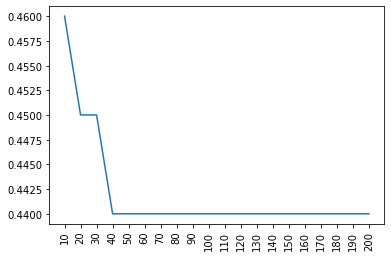

In [32]:
plt.xticks(range(10, 201, 10), rotation ='vertical')
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

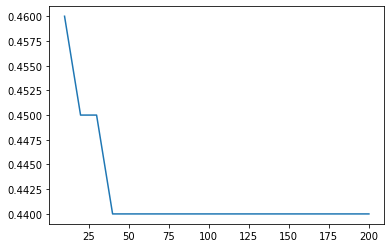

After which value of `n_estimators` does RMSE stop improving?

- 10
- <font color='red'>(X)</font> 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [33]:
max_depth_scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1, 
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        max_depth_scores.append((d, n, rmse))

In [36]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(max_depth_scores, columns=columns)

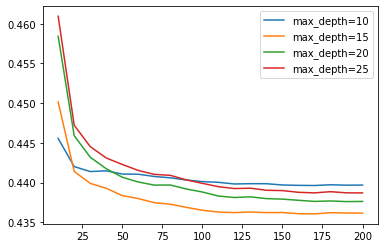

In [37]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* <font color='red'>(X)</font> 15
* 20
* 25

Bonus question (not graded):
    
Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [38]:
rf = RandomForestRegressor(n_estimators=10,
                                    max_depth=20,
                                    random_state=1, 
                                    n_jobs=-1)

In [40]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [41]:
rf.feature_importances_

array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

<BarContainer object of 15 artists>

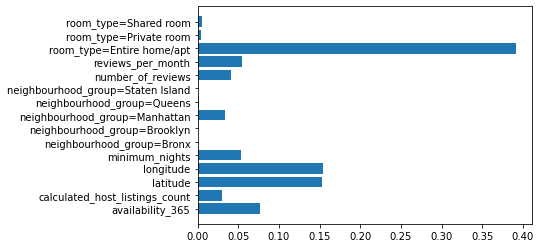

In [44]:
plt.barh(dv.get_feature_names(), rf.feature_importances_)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* <font color='red'>(X)</font> `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [47]:
!pip install xgboost

In [48]:
import xgboost as xgb

In [49]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [77]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [78]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [79]:
%%capture output
model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  evals=watchlist)


In [80]:
s = output.stdout

In [81]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [67]:
scores = {}

In [82]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [83]:
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          1     2.14667   2.14390
 2          2     1.53878   1.53721
 3          3     1.12557   1.12523
 4          4     0.85100   0.85174
 ..       ...         ...       ...
 95        95     0.36742   0.43579
 96        96     0.36698   0.43584
 97        97     0.36644   0.43595
 98        98     0.36582   0.43597
 99        99     0.36478   0.43621
 
 [100 rows x 3 columns],
 'eta=0.1':     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          1     3.49150   3.48840
 2          2     3.14949   3.14635
 3          3     2.84232   2.83951
 4          4     2.56650   2.56412
 ..       ...         ...       ...
 95        95     0.40406   0.43272
 96        96     0.40397   0.43272
 97        97     0.40361   0.43269
 98        98     0.40321   0.43260
 99        99     0.40277   0.43250
 
 [100 rows x 3 columns],
 'eta=0.01':     num_iter  train_rmse  val_rmse
 0          

Now change `eta` first to `0.1` and then to `0.01`

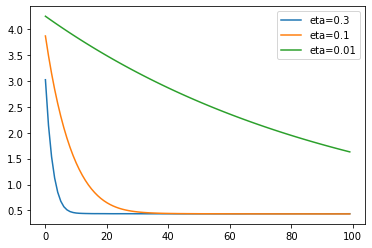

In [86]:
for eta in scores.keys():
    plt.plot(scores[eta]['num_iter'], scores[eta]['val_rmse'], label=eta)

# plt.ylim(0, 1.5)
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* <font color='red'>(X)</font> 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

